In [1]:
from time import time
import json
import numpy as np
import os
from stable_baselines3 import TD3 as sb3TD3
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from IPython.display import clear_output
import matplotlib.pyplot as plt
import copy
from hyperopt import fmin, tpe, hp
import pickle
from torch import Tensor
# simple stopwatch to time whatevs, in (float) seconds
# keeps track of laps along with final time
class Stopwatch:
    def __init__(self):
            self.start_time = time()
            self.last_time = self.start_time
            self.laps = []
    def lap(self):
        this_time = time()
        delta_time = this_time - self.last_time
        self.laps.append(delta_time)
        self.last_time = this_time
        return delta_time
    def stop(self):
        self.stop_time = time()
        self.delta_time = self.stop_time - self.start_time
        return self.delta_time
class Slim(nn.Linear):
    def __init__(self, max_in_features: int, max_out_features: int, bias: bool = True,
                 device=None, dtype=None,
                slim_in=True, slim_out=True) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        super().__init__(max_in_features, max_out_features, bias, device, dtype)
        self.max_in_features = max_in_features
        self.max_out_features = max_out_features
        self.slim_in = slim_in
        self.slim_out = slim_out
        self.slim = 1
        
    def forward(self, input: Tensor) -> Tensor:
        if self.slim_in:
            self.in_features = int(self.slim * self.max_in_features)
        if self.slim_out:
            self.out_features = int(self.slim * self.max_out_features)
        weight = self.weight[:self.out_features, :self.in_features]
        if self.bias is not None:
            bias = self.bias[:self.out_features]
        else:
            bias = self.bias
        y = F.linear(input, weight, bias)
        return y

In [2]:
data_dir = 'data_beta/' # horizontal, 25x25 forward and belly depths
observations = {}
files = os.listdir(data_dir)
for fname in files:
    fpath = data_dir + fname
    if 'observations' in fname:
        observation_set = np.load(fpath, allow_pickle=True)
        observations.update(observation_set)
Xs = {
    'train':[],
    'val':[],
    'test':[],
}
Ys = {
    'train':[],
    'val':[],
    'test':[],
}
XYs = {
    'train':[],
    'val':[],
    'test':[],
}
Qs = {
    'train':[],
    'val':[],
    'test':[],
}

# distance normalization parameters
min_input = 125/1000 # min depth (below this is erroneous)
max_input = 125 # max depth
min_output = 0.1 # reserve 0 for no-data
max_output = 1 
left = 0 # set all values below range to this
right = None

nSteps = []
for fname in files:
    fpath = data_dir + fname
    if 'states' in fname:
        jdict = json.load(open(fpath, 'r'))
        for episode in jdict:
            gfile = jdict[episode]['step_0']['fname']
            if 'part2' in gfile or 'part3' in gfile or 'vertical' in gfile:
                continue
            if 'train' in gfile:
                batch = 'train'
            if 'val' in gfile:
                batch = 'val'
            if 'test' in gfile:
                batch = 'test'
            nSteps.append(len(jdict[episode])-1)
            start = np.array(jdict[episode]['step_0']['drone_position'], dtype=float)
            goal = np.array(jdict[episode]['step_0']['goal_position'], dtype=float)
            last_distance = np.linalg.norm(goal-start)
            rs = []
            norm_verts = [0, 0, 0, 0]
            for step in jdict[episode]:
                if step == 'step_0':
                    continue
                state = jdict[episode][step]
                actions = state['rl_output'][:2]
                observation_name = state['observation_name']
                observation = observations[observation_name]
                drone = np.array(state['drone_position'], dtype=float)
                this_distance = np.linalg.norm(goal-drone)
                delta_distance = last_distance - this_distance
                vert_distance = abs((goal - drone)[2])
                norm_vert = np.interp(vert_distance,
                     (min_input, max_input),
                     (min_output, max_output),
                   left=left,
                   right=right,
                )
                # rotate norm_verts
                norm_verts[3] = norm_verts[2]
                norm_verts[2] = norm_verts[1]
                norm_verts[1] = norm_verts[0]
                norm_verts[0] = norm_vert
                
                x_old = list(observation)
                x = np.zeros(len(x_old) + 4, dtype=float)
                for i in range(4):
                    l1 = i*53
                    l2 = i*52
                    x[l1:l1+53] = x_old[l2+2:l2+52] + [x_old[l2+0], x_old[l2+1], norm_verts[i]]
                x = list(x)
                Xs[batch].append(x)
                y_old = list(np.clip(actions, -1, 1)) # forward, rotate
                y = [y_old[0], 0, y_old[1]]#, 1, 1, 1] # forward, vertical, rotate, slim, res1, res2
                Ys[batch].append(y)
                XYs[batch].append(x + y)
                
                if this_distance <= 4:
                    r = 100
                else:
                    r = .1*np.tanh(delta_distance) - 1
                rs.append(r)
                if this_distance <= 4:
                    break
                    
                last_distance = this_distance
                
            qs = [100]
            gamma = 0.99
            for i in range(len(rs)-2,-1,-1):
                qs.append(rs[i] + gamma * qs[-1])
            qs = qs[::-1]
            Qs[batch] = Qs[batch] + qs
for batch in Xs:
    Xs[batch] = np.array(Xs[batch])
for batch in Ys:
    Ys[batch] = np.array(Ys[batch])
for batch in XYs:
    XYs[batch] = np.array(XYs[batch])
for batch in Qs:
    Qs[batch] = np.array(Qs[batch])

In [3]:
data_dir = 'SECON3_Navi_Horz/'

In [4]:
Xs['train'].shape

(8890, 212)

In [6]:
class DatasetActor(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = torch.as_tensor(X.copy(), device = torch.device("cuda")).float()
        self.y = torch.as_tensor(y.copy(), device = torch.device("cuda")).float()

    def __len__(self):
        return len(self.y)

    def __getitem__(self, index):
        return self.X[index], self.y[index]
    
training_set = DatasetActor(Xs['train'], Ys['train'])
validation_set = DatasetActor(Xs['val'], Ys['val'])
testing_set = DatasetActor(Xs['test'], Ys['test'])

batch_size = 32
params = {'batch_size': batch_size,
          'shuffle': True,}
training_loader = torch.utils.data.DataLoader(training_set, **params)
params = {'batch_size': batch_size,
          'shuffle': False,}
validation_loader = torch.utils.data.DataLoader(validation_set, **params)
testing_loader = torch.utils.data.DataLoader(testing_set, **params)

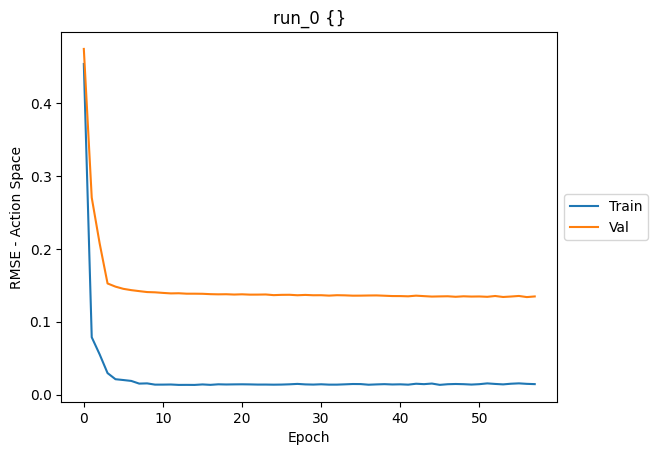

In [ ]:
table = []
save_model = True
if not save_model and os.path.exists(data_dir + 'actor_hyperopt.p'):
    file = open(data_dir + 'actor_hyperopt.p', 'rb')
    table = pickle.load(file)
if save_model and os.path.exists(data_dir + 'models/actor_runs.p'):
    file = open(data_dir + 'models/actor_runs.p', 'rb')
    table = pickle.load(file)

def objective(params, save_model=False, name=None):
    sw = Stopwatch()
    
    #nLayers = int(3)
    #nNodes = 2**int(5)
    net_arch = [64, 32, 32]
    nLayers = len(net_arch)
    learning_rate = 10**(int(-1*3))/4 #params['learning_rate']))
    weight_decay = 10**(int(-1*6))
    eps = 1e-8#10**(int(-1*int(params['eps'])))
    patience = 10#int(params['patience'])

    activation_fn = nn.ReLU
    with_bias = True
    input_dim = Xs['train'].shape[1]
    output_dim = Ys['train'].shape[1]

    modules = []
    if nLayers == 0:
        modules.append(Slim(input_dim, output_dim, bias=with_bias, slim_in=False, slim_out=False))
    else:
        modules.append(Slim(input_dim, net_arch[0], bias=with_bias, slim_in=False))
        modules.append(activation_fn())
        for idx in range(len(net_arch) - 1):
            modules.append(Slim(net_arch[idx], net_arch[idx + 1], bias=with_bias))
            modules.append(activation_fn())
        modules.append(Slim(net_arch[-1], output_dim, bias=with_bias, slim_out=False))
    modules.append(nn.Tanh())
    
    actor = nn.Sequential(*modules)
    device = torch.device("cuda")
    actor.cuda()
    actor.optimizer = torch.optim.Adam(
        actor.parameters(),
        amsgrad=False,
        betas= (0.9, 0.999),
        capturable= False,
        differentiable= False,
        eps= eps,
        foreach= None,
        fused= False,
        lr= learning_rate,
        maximize= False,
        weight_decay= weight_decay,
    )

    criterion = nn.MSELoss()
    max_epochs = 10_000
    nTrain = training_set.X.size()[0]
    nVal = validation_set.X.size()[0]
    nTest = testing_set.X.size()[0]
    train_rmses = []
    val_rmses = []
    wait = 0
    best_val = 999_999
    best_weights = copy.deepcopy(actor.state_dict())

    test_rmses = []
    test_sse = 0
    for i, data in enumerate(testing_loader):
        x, y = data
        p = actor(x)
        loss = criterion(p, y)
        test_mse = loss.detach().cpu().numpy()
        test_sse += test_mse * x.size()[0]
    test_rmse = math.sqrt(test_sse / nTest)
    test_rmses.append(test_rmse)

    train_sse = 0
    for i, data in enumerate(training_loader):
        x, y = data
        p = actor(x)
        loss = criterion(p, y)
        train_mse = loss.detach().cpu().numpy()
        train_sse += train_mse * x.size()[0]
    train_rmse = math.sqrt(train_sse / nTrain)
    train_rmses.append(train_rmse)

    val_sse = 0
    for i, data in enumerate(validation_loader):
        x, y = data
        p = actor(x)
        loss = criterion(p, y)
        val_mse = loss.detach().cpu().numpy()
        val_sse += val_mse * x.size()[0]
    val_rmse = math.sqrt(val_sse / nVal)
    val_rmses.append(val_rmse)


    for epoch in range(max_epochs):

        train_sse = 0
        for i, data in enumerate(training_loader):
            x, y = data
            p = actor(x)
            actor.optimizer.zero_grad()
            loss = criterion(p, y)
            loss.backward(retain_graph=True)
            # inplace distillation 
            sample_slim = np.random.uniform(low=0.125, high=1.0, size=2)
            slim_samples = [0.125] + list(sample_slim)
            for slim in slim_samples:
                for module in actor.modules():
                    if 'Slim' in str(type(module)):
                        module.slim = slim
                p2 = actor(x)
                loss = criterion(p2, p)
                loss.backward(retain_graph=True)
            for module in actor.modules():
                if 'Slim' in str(type(module)):
                    module.slim = 1
            actor.optimizer.step()
            train_mse = loss.detach().cpu().numpy()
            train_sse += train_mse * x.size()[0]
            
        train_rmse = math.sqrt(train_sse / nTrain)
        train_rmses.append(train_rmse)

        val_sse = 0
        for i, data in enumerate(validation_loader):
            x, y = data
            p = actor(x)
            loss = criterion(p, y)
            val_mse = loss.detach().cpu().numpy()
            val_sse += val_mse * x.size()[0]
        val_rmse = math.sqrt(val_sse / nVal)
        val_rmses.append(val_rmse)

        clear_output(wait=True)
        plt.plot(train_rmses, label='Train')
        plt.plot(val_rmses, label='Val')
        plt.title(name + ' ' + str(params))
        plt.xlabel('Epoch')
        plt.ylabel('RMSE - Action Space')
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.show()

        if val_rmse < best_val:
            best_val = val_rmse
            best_weights = copy.deepcopy(actor.state_dict())
            wait = 0
        else:
            wait += 1
        if wait > patience:
            break

    actor.load_state_dict(best_weights)

    test_sse = 0
    for i, data in enumerate(testing_loader):
        x, y = data
        p = actor(x)
        loss = criterion(p, y)
        test_mse = loss.detach().cpu().numpy()
        test_sse += test_mse * x.size()[0]
    test_rmse = math.sqrt(test_sse / nTest)
    test_rmses.append(test_rmse)
                       
    dt = sw.stop()
                       
    results = params.copy()
    results['time'] = dt
    results['train'] = train_rmses
    results['val'] = val_rmses
    results['test'] = test_rmses
    table.append(results)
    if save_model:
        file = open(data_dir + 'models/actor_runs.p', 'wb')
        pickle.dump(table, file)
        path = data_dir + 'models/actor_' + name + '.pt'
        torch.save(actor.state_dict(), path)
    else:
        file = open(data_dir + 'actor_hyperopt.p', 'wb')
        pickle.dump(table, file)           
    return test_rmses[1]
                       

'''                       
# define grid space of hyperparameters to explore
space = {
    'nLayers':hp.quniform('nLayers', 0, 18, 1),
    'nNodes':hp.quniform('nNodes', 0, 14, 1),
    #'learning_rate':hp.quniform('learning_rate', 2, 10, 1),
    'weight_decay':hp.quniform('weight_decay', 0, 20, 1),
    #'eps':hp.quniform('eps', -2, 4, 1),
    #'patience':hp.quniform('patience', 10, 40, 1),
}
# run Hyperopt - minimizing the objective function, with the given grid space, using TPE method, and 16 max iterations
best = fmin(objective, space, algo=tpe.suggest, max_evals=100)
'''
'''
for nLayers in range(0, 11):
    for nNodes in range(0, 11):
        for weight_decay in range(0, 11):
            objective({
                'nLayers':nLayers,
                'nNodes':nNodes,
                'weight_decay':weight_decay,
            })
'''
nRuns = 100
for run in range(nRuns):
    name = 'run_' + str(run)
    objective({}, save_model=True, name=name)

In [ ]:
class DatasetCritic(torch.utils.data.Dataset):
    def __init__(self, Xy, q):
        self.Xy = torch.as_tensor(Xy.copy(), device = torch.device("cpu")).float()
        self.q = torch.as_tensor(q.copy(), device = torch.device("cpu")).float()

    def __len__(self):
        return len(self.q)

    def __getitem__(self, index):
        return self.Xy[index], self.q[index]
    
training_set = DatasetCritic(XYs['train'], Qs['train'])
validation_set = DatasetCritic(XYs['val'], Qs['val'])
testing_set = DatasetCritic(XYs['test'], Qs['test'])

batch_size = 32
params = {'batch_size': batch_size,
          'shuffle': True,}
training_loader = torch.utils.data.DataLoader(training_set, **params)
params = {'batch_size': batch_size,
          'shuffle': False,}
validation_loader = torch.utils.data.DataLoader(validation_set, **params)
testing_loader = torch.utils.data.DataLoader(testing_set, **params)

In [ ]:
table = []
save_model = True
if not save_model and os.path.exists(data_dir + 'critic_hyperopt.p'):
    file = open(data_dir + 'critic_hyperopt.p', 'rb')
    table = pickle.load(file)
if save_model and os.path.exists(data_dir + 'models/critic_runs.p'):
    file = open(data_dir + 'models/critic_runs.p', 'rb')
    table = pickle.load(file)

def objective(params, save_model=False, name=None):
    sw = Stopwatch()
    
    #nLayers = int(3)
    #nNodes = 2**int(5)
    net_arch = [64, 32, 32]
    nLayers = len(net_arch)
    learning_rate = 10**(int(-1*3))/4 #params['learning_rate']))
    weight_decay = 10**(int(-1*6))
    eps = 1e-8#10**(int(-1*int(params['eps'])))
    patience = 10#int(params['patience'])

    activation_fn = nn.ReLU
    with_bias = True
    input_dim = Xs['train'].shape[1] + Ys['train'].shape[1]
    output_dim = 1

    modules = []
    if nLayers == 0:
        modules.append(Slim(input_dim, output_dim, bias=with_bias, slim_in=False, slim_out=False))
    else:
        modules.append(Slim(input_dim, net_arch[0], bias=with_bias, slim_in=False))
        modules.append(activation_fn())
        for idx in range(len(net_arch) - 1):
            modules.append(Slim(net_arch[idx], net_arch[idx + 1], bias=with_bias))
            modules.append(activation_fn())
        modules.append(Slim(net_arch[-1], output_dim, bias=with_bias, slim_out=False))
    
    critic = nn.Sequential(*modules)
    device = torch.device("cpu")
    critic.cpu()
    critic.optimizer = torch.optim.Adam(
        critic.parameters(),
        amsgrad=False,
        betas= (0.9, 0.999),
        capturable= False,
        differentiable= False,
        eps= eps,
        foreach= None,
        fused= False,
        lr= learning_rate,
        maximize= False,
        weight_decay= weight_decay,
    )

    criterion = nn.MSELoss()
    max_epochs = 1000
    nTrain = training_set.Xy.size()[0]
    nVal = validation_set.Xy.size()[0]
    nTest = testing_set.Xy.size()[0]
    train_rmses = []
    val_rmses = []
    wait = 0
    best_val = 999_999
    best_weights = copy.deepcopy(critic.state_dict())

    test_rmses = []
    test_sse = 0
    for i, data in enumerate(testing_loader):
        xy, q = data
        p = critic(xy)
        loss = criterion(p, q)
        test_mse = loss.detach().cpu().numpy()
        test_sse += test_mse * xy.size()[0]
    test_rmse = math.sqrt(test_sse / nTest)
    test_rmses.append(test_rmse)

    train_sse = 0
    for i, data in enumerate(training_loader):
        xy, q = data
        p = critic(xy)
        loss = criterion(p, q)
        train_mse = loss.detach().cpu().numpy()
        train_sse += train_mse * xy.size()[0]
    train_rmse = math.sqrt(train_sse / nTrain)
    train_rmses.append(train_rmse)

    val_sse = 0
    for i, data in enumerate(validation_loader):
        xy, q = data
        p = critic(xy)
        loss = criterion(p, q)
        val_mse = loss.detach().cpu().numpy()
        val_sse += val_mse * xy.size()[0]
    val_rmse = math.sqrt(val_sse / nVal)
    val_rmses.append(val_rmse)


    for epoch in range(max_epochs):

        train_sse = 0
        for i, data in enumerate(training_loader):
            xy, q = data
            p = critic(xy)
            loss = criterion(p, q)
            critic.optimizer.zero_grad()
            loss.backward()
            critic.optimizer.step()
            train_mse = loss.detach().cpu().numpy()
            train_sse += train_mse * xy.size()[0]
        train_rmse = math.sqrt(train_sse / nTrain)
        train_rmses.append(train_rmse)

        val_sse = 0
        for i, data in enumerate(validation_loader):
            xy, q = data
            p = critic(xy)
            loss = criterion(p, q)
            val_mse = loss.detach().cpu().numpy()
            val_sse += val_mse * xy.size()[0]
        val_rmse = math.sqrt(val_sse / nVal)
        val_rmses.append(val_rmse)

        clear_output(wait=True)
        plt.plot(train_rmses, label='Train')
        plt.plot(val_rmses, label='Val')
        plt.title(name + ' ' + str(params))
        plt.xlabel('Epoch')
        plt.ylabel('RMSE - Q Value')
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.show()

        if val_rmse < best_val:
            best_val = val_rmse
            best_weights = copy.deepcopy(critic.state_dict())
            wait = 0
        else:
            wait += 1
        if wait > patience:
            break

    critic.load_state_dict(best_weights)

    test_sse = 0
    for i, data in enumerate(testing_loader):
        xy, q = data
        p = critic(xy)
        loss = criterion(p, q)
        test_mse = loss.detach().cpu().numpy()
        test_sse += test_mse * xy.size()[0]
    test_rmse = math.sqrt(test_sse / nTest)
    test_rmses.append(test_rmse)
                       
    dt = sw.stop()
                       
    results = params.copy()
    results['time'] = dt
    results['train'] = train_rmses
    results['val'] = val_rmses
    results['test'] = test_rmses
    table.append(results)
    if save_model:
        file = open(data_dir + 'models/critic_runs.p', 'wb')
        pickle.dump(table, file)
        path = data_dir + 'models/critic_' + name + '.pt'
        torch.save(critic.state_dict(), path)
    else:
        file = open(data_dir + 'critic_hyperopt.p', 'wb')
        pickle.dump(table, file)           
    return test_rmses[1]
                       

'''                       
# define grid space of hyperparameters to explore
space = {
    'nLayers':hp.quniform('nLayers', 0, 18, 1),
    'nNodes':hp.quniform('nNodes', 0, 14, 1),
    #'learning_rate':hp.quniform('learning_rate', 2, 10, 1),
    'weight_decay':hp.quniform('weight_decay', 0, 20, 1),
    #'eps':hp.quniform('eps', -2, 4, 1),
    #'patience':hp.quniform('patience', 10, 40, 1),
}}}}
# run Hyperopt - minimizing the objective function, with the given grid space, usdata_dirdata_dirdata_diring TPE method, and 16 max iterations
best = fmin(objective, space, algo=tpe.suggest, max_evals=100)
'''
'''
for nLayers in range(0, 11):
    for nNodes in range(0, 11):
        for weight_decay in range(0, 11):
            objective({
                'nLayers':nLayers,
                'nNodes':nNodes,
                'weight_decay':weight_decay,
            })
'''
nRuns = 100
for run in range(nRuns):
    name = 'run_' + str(run)
    objective({}, save_model=True, name=name)